In [13]:
import requests
import pandas as pd
import time
import sys
import re
import matplotlib.pyplot as plt

import woo_hoo

from pathlib import Path
from rapidfuzz import fuzz
from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle,
    ListFlowable, ListItem, PageBreak
)
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors
from reportlab.lib.units import inch
from reportlab.lib.pagesizes import A4


from woo_hoo.services.document_extractor import extract_text_from_bytes
from woo_hoo.services.metadata_generator import MetadataGenerator
from woo_hoo.models.requests import MetadataGenerationRequest, DocumentContent





## Data inladen uitproberen

In [14]:
url = "https://open.overheid.nl/overheid/openbaarmakingen/api/v0/zoek"
params = {
    "zoektekst": "klimaat",
    "start": 0,
    "aantalResultaten": 20
}

response = requests.get(url, params=params)
data = response.json()

display(data)


{'totaal': 112269,
 'resultaten': [{'document': {'id': 'oep-c2a77d8f9db144541bc3ba4c0b66aadfa55468a9_1',
    'pid': 'https://open.overheid.nl/documenten/oep-c2a77d8f9db144541bc3ba4c0b66aadfa55468a9',
    'titel': 'Wet van 28 januari 2026, houdende wijziging van de begrotingsstaten van het Ministerie van Klimaat en Groene Groei (XXIII) voor het jaar 2025 (wijziging samenhangende met de Najaarsnota)',
    'openbaarmakingsdatum': '2026-02-17',
    'weblocatie': 'https://zoek.officielebekendmakingen.nl/stb-2026-35.html',
    'publisher': 'ministerie van Justitie en Veiligheid',
    'aanbieder': 'officielebekendmakingen.nl',
    'mutatiedatumtijd': '2026-02-17T08:24:20.969Z'},
   'bestandsgrootte': '0.06 MB',
   'bestandsType': 'application/pdf',
   'highlightedText': 'Staatsblad van het Koninkrijk der Nederlanden Wet van 28 januari 2026 houdende wijziging van de begrotingsstaten van het Ministerie van <b>Klimaat</b> en Groene Groei XXIII voor het jaar 2025 wijziging samenhangende ...  Alzo

In [15]:
print(data.keys())

dict_keys(['totaal', 'resultaten', 'filters'])


In [16]:
# voorbeeld metadata van document
data["resultaten"][0]

{'document': {'id': 'oep-c2a77d8f9db144541bc3ba4c0b66aadfa55468a9_1',
  'pid': 'https://open.overheid.nl/documenten/oep-c2a77d8f9db144541bc3ba4c0b66aadfa55468a9',
  'titel': 'Wet van 28 januari 2026, houdende wijziging van de begrotingsstaten van het Ministerie van Klimaat en Groene Groei (XXIII) voor het jaar 2025 (wijziging samenhangende met de Najaarsnota)',
  'openbaarmakingsdatum': '2026-02-17',
  'weblocatie': 'https://zoek.officielebekendmakingen.nl/stb-2026-35.html',
  'publisher': 'ministerie van Justitie en Veiligheid',
  'aanbieder': 'officielebekendmakingen.nl',
  'mutatiedatumtijd': '2026-02-17T08:24:20.969Z'},
 'bestandsgrootte': '0.06 MB',
 'bestandsType': 'application/pdf',
 'highlightedText': 'Staatsblad van het Koninkrijk der Nederlanden Wet van 28 januari 2026 houdende wijziging van de begrotingsstaten van het Ministerie van <b>Klimaat</b> en Groene Groei XXIII voor het jaar 2025 wijziging samenhangende ...  Alzo Wij in overweging genomen hebben dat de noodzaak is ge

## Testset maken

In [17]:
def fetch_official_metadata(doc_id: str) -> dict:
    url = f"https://open.overheid.nl/overheid/openbaarmakingen/api/v0/zoek/{doc_id}"
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

In [18]:
def fetch_doc_ids_with_pdf(n=20):
    base_url = "https://open.overheid.nl/overheid/openbaarmakingen/api/v0/zoek"
    
    doc_ids = []
    start = 0
    
    while len(doc_ids) < n:
        
        params = {
            "zoektekst": "",
            "start": start,
            "aantalResultaten": 20
        }

        response = requests.get(base_url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()

        results = data.get("resultaten", [])
        if not results:
            break

        for r in results:
            doc_id = r["document"]["id"]
            
            detail = fetch_official_metadata(doc_id)
            time.sleep(0.2)

            if not detail:
                continue

            pdf_url = None
            versies = detail.get("versies") or []

            if len(versies) > 0:
                bestanden = versies[0].get("bestanden") or []
                if len(bestanden) > 0:
                    pdf_url = bestanden[0].get("id")

            if pdf_url:
                doc_ids.append(doc_id)

            if len(doc_ids) >= n:
                break

        start += 20

    return doc_ids


In [19]:
doc_ids = fetch_doc_ids_with_pdf(20)
doc_ids


['oep-176b112ad57823b079d9d77d4c3b9612da71794d_1',
 'oep-3545df8a3496083a71e604c49df0d30716563e24_1',
 'oep-572b8ed8d32bbf9c932a039ef3c14b415af8229a_1',
 'oep-75457ec0e9a8201c369796fb344488e7d175c7d7_1',
 'oep-ob-30feb22d6438ae1fb25120003573d621734f44be_3',
 'oep-ob-c6f29aa1bf5032b4a301db8a7021a69d72fbd73d_1',
 'oep-12ae6fe5ca7f3d3eae50350c743411d715feed73_1',
 'oep-33d33760c464c79c296e0b2905c26e42a5de465b_1',
 'oep-4eddc4eb58cef4a329d8069c8d3d39d67bf81a9f_1',
 'oep-5db592e9c84f7fc0c632b5ce24424d82adea92ca_1',
 'oep-adcbacc16876bc39f091658157262f16cb9d91ab_1',
 'oep-e9e372239ba55efd26201d59c332248bd14692cc_1',
 'oep-02cfe67feb4519d390d51aeb83f80c854e2a1c16_1',
 'oep-047293f11f02ee6029cb58b61c56ef5f768383c0_1',
 'oep-0f189284451533a80ec0d2e0bf06a7da99f0e674_1',
 'oep-139f418f3f14eb762b5f22ff4ef8b382b0685dde_1',
 'oep-1576bdc3586d1a3c64420c00c7272b27f2cc69fb_1',
 'oep-1d91e34ab5ae972bd395b957f5d55df28fc7862a_1',
 'oep-22dbba96f6892e2bfbbc2da929ac373ea539316b_1',
 'oep-39cd1b14d2fb2f2f61b

## Meta-data genereren a.d.h.v. bestaande back-end

In [20]:
# PDF url om te testen
pdf_url = "https://open.overheid.nl/documenten/oep-ob-35b90fb89d64b1009ae2a22c8afde5733aab839a/pdf"

In [34]:
generator = MetadataGenerator()

async def generate_metadata_from_pdf_url(pdf_url: str):
    # 1. Download PDF
    response = requests.get(pdf_url)
    response.raise_for_status()
    pdf_bytes = response.content

    # 2. Extract text
    try:
        text = extract_text_from_bytes(pdf_bytes, filename="document.pdf")
    except Exception:
        return None

    # 3. Build request
    request = MetadataGenerationRequest(
        document=DocumentContent(
            text=text,
            filename="document.pdf",
            source_url=pdf_url
        ),
        include_confidence=True
    )

    # 4. Generate metadata
    result = await generator.generate(request)

    return result


In [22]:
FIELDS_TO_COMPARE = {
    "direct_fields": [
        "titel",
        "omschrijving",
        "identifiers",
        # "creatiedatum",
        "informatiecategorieen",
        "documentsoorten",
        "trefwoorden",
        "naam_opsteller"
    ],
    "organisation_fields": [
        "publisher",
        "verantwoordelijke",
        "opsteller"
    ]
}

STRATEGIES = [
    "semantic_similarity",   # fuzzy string
    "semantic_overlap",      # lijst fuzzy
    "set_overlap",           # identifiers
    "exact_match",           # datum
    "fuzzy_string"           # organisaties / naam
]

COMPARISON_STRATEGY = {
    "titel": "semantic_similarity",
    "omschrijving": "semantic_similarity",
    "identifiers": "set_overlap",
    # "creatiedatum": "exact_match",
    "informatiecategorieen": "semantic_overlap",
    "documentsoorten": "semantic_overlap",
    "trefwoorden": "semantic_overlap",
    "naam_opsteller": "fuzzy_string",
    "publisher": "fuzzy_string",
    "verantwoordelijke": "fuzzy_string",
    "opsteller": "fuzzy_string",
}


### Normalisatie en vergelijkingsfuncties

In [23]:
# helper functie voor normalisatie
def normalize_text(text: str | None) -> str:
    if not text:
        return ""
    
    text = text.lower()
    text = re.sub(r"[_\-]", " ", text)
    text = re.sub(r"\s+", " ", text)

    return text.strip()


In [24]:
def compare_semantic_similarity(a: str | None, b: str | None) -> float:
    a_norm = normalize_text(a)
    b_norm = normalize_text(b)
    
    if not a_norm or not b_norm:
        return 0.0
    
    return fuzz.token_set_ratio(a_norm, b_norm) / 100

In [25]:
def compare_semantic_overlap(list_a, list_b) -> float:
    if not list_a or not list_b:
        return 0.0

    scores = []

    for item_a in list_a:
        a_norm = normalize_text(item_a)
        best_score = 0

        for item_b in list_b:
            b_norm = normalize_text(item_b)
            score = fuzz.token_set_ratio(a_norm, b_norm)
            best_score = max(best_score, score)

        scores.append(best_score / 100)

    return sum(scores) / len(scores)

In [26]:
def compare_set_overlap(list_a, list_b) -> float:
    if not list_a or not list_b:
        return 0.0

    set_a = set(normalize_text(x) for x in list_a)
    set_b = set(normalize_text(x) for x in list_b)

    intersection = set_a.intersection(set_b)
    union = set_a.union(set_b)

    if not union:
        return 0.0

    return len(intersection) / len(union)

In [27]:
def compare_exact_match(a, b) -> float:
    return 1.0 if a == b else 0.0

In [28]:
def compare_fuzzy_string(a: str | None, b: str | None) -> float:
    return compare_semantic_similarity(a, b)

In [29]:
# u
def compare_field(field_name, official_value, llm_value):
    strategy_map = {
        "titel": compare_semantic_similarity,
        "omschrijving": compare_semantic_similarity,
        "informatiecategorieen": compare_semantic_overlap,
        "documentsoorten": compare_semantic_overlap,
        "trefwoorden": compare_semantic_overlap,
        "identifiers": compare_set_overlap,
        # "creatiedatum": compare_exact_match,
        "naam_opsteller": compare_fuzzy_string,
        "publisher": compare_fuzzy_string,
        "verantwoordelijke": compare_fuzzy_string,
        "opsteller": compare_fuzzy_string,
    }

    func = strategy_map[field_name]
    return func(official_value, llm_value)


### Extractiefuncties

In [30]:
def extract_official_fields(official_json: dict) -> dict:
    doc = official_json.get("document", official_json)

    # --- Omschrijving robuust ophalen ---
    omschrijving = (
        doc.get("omschrijving")
        or (
            doc.get("omschrijvingen")[0]
            if doc.get("omschrijvingen")
            else None
        )
    )

    return {
        "titel": doc.get("titel") 
                 or doc.get("titelcollectie", {}).get("officieleTitel"),

        "omschrijving": omschrijving,

        "identifiers": doc.get("identifiers"),

        "informatiecategorieen": [
            cat.get("label")
            for cat in doc.get("classificatiecollectie", {})
                          .get("informatiecategorieen", [])
        ],

        "documentsoorten": [
            soort.get("label")
            for soort in doc.get("classificatiecollectie", {})
                            .get("documentsoorten", [])
        ],

        "trefwoorden": (
            doc.get("classificatiecollectie", {})
               .get("trefwoorden")
            or []
        ),

        "naam_opsteller": doc.get("naamOpsteller"),

        "publisher": (
            doc.get("publisher", {}).get("label")
            if isinstance(doc.get("publisher"), dict)
            else doc.get("publisher")
        ),

        "verantwoordelijke": (
            doc.get("verantwoordelijke", {}).get("label")
            if isinstance(doc.get("verantwoordelijke"), dict)
            else None
        ),

        "opsteller": (
            doc.get("opsteller", {}).get("label")
            if isinstance(doc.get("opsteller"), dict)
            else None
        ),
    }


In [31]:
def extract_llm_fields(diwoo_metadata) -> dict:
    """Functie voor het structureren van gegenereerde metadata"""
    
    
    return {
        "titel": diwoo_metadata.titelcollectie.officiele_titel,

        "omschrijving": (
            diwoo_metadata.omschrijvingen[0]
            if diwoo_metadata.omschrijvingen
            else None
        ),

        "identifiers": diwoo_metadata.identifiers,

        "informatiecategorieen": [
            cat.categorie.name
            for cat in diwoo_metadata.classificatiecollectie.informatiecategorieen
        ],

        "documentsoorten": [
            soort.soort.name
            for soort in diwoo_metadata.classificatiecollectie.documentsoorten or []
        ],

        "trefwoorden": diwoo_metadata.classificatiecollectie.trefwoorden,

        "naam_opsteller": diwoo_metadata.naam_opsteller,

        "publisher": diwoo_metadata.publisher.label if diwoo_metadata.publisher else None,

        "verantwoordelijke": (
            diwoo_metadata.verantwoordelijke.label
            if diwoo_metadata.verantwoordelijke else None
        ),

        "opsteller": (
            diwoo_metadata.opsteller.label
            if diwoo_metadata.opsteller else None
        ),
    }


In [36]:
async def benchmark_single_document(doc_id: str):
    
    # 1. Officiële metadata
    official_metadata_json = fetch_official_metadata(doc_id)
    official_fields = extract_official_fields(official_metadata_json)
    
    # 2. PDF URL ophalen
    pdf_url = official_metadata_json.get("versies", [{}])[0] \
                                     .get("bestanden", [{}])[0] \
                                     .get("id")
    
    if not pdf_url:
        return None  # skip als geen pdf
    
    # 3. LLM metadata genereren
    result = await generate_metadata_from_pdf_url(pdf_url)
    
    if result is None:
        return None

    if not result.success:
        return None
        
    llm_fields = extract_llm_fields(result.suggestion.metadata)
    
    # 4. Scores berekenen
    rows = []
    
    for field, official_value in official_fields.items():
        
        if field == "creatiedatum":
            continue
        
        if official_value is None:
            continue
        
        if isinstance(official_value, list) and len(official_value) == 0:
            continue
        
        llm_value = llm_fields.get(field)
        score = compare_field(field, official_value, llm_value)
        
        if score is None:
            continue
        
        rows.append({
            "doc_id": doc_id,
            "field": field,
            "official_value": official_value,
            "llm_value": llm_value,
            "score": score
        })
    
    return pd.DataFrame(rows)


In [37]:
dfs = []

for doc_id in doc_ids:
    df_doc = await benchmark_single_document(doc_id)
    if df_doc is not None:
        dfs.append(df_doc)

benchmark_df = pd.concat(dfs, ignore_index=True)
benchmark_df


2026-02-19 13:49:03 [info     ] Starting metadata generation   has_publisher_hint=False output_mode=xml request_id=c1e30cc1-4ae2-40a8-b60f-bb9ca7742d45 text_length=8678
2026-02-19 13:49:24 [info     ] OpenRouter request completed   elapsed_ms=21886 model=mistralai/mistral-large-2512
2026-02-19 13:49:24 [info     ] Metadata generation completed  elapsed_ms=21889 output_mode=xml overall_confidence=0.8 request_id=c1e30cc1-4ae2-40a8-b60f-bb9ca7742d45
2026-02-19 13:49:25 [info     ] Starting metadata generation   has_publisher_hint=False output_mode=xml request_id=917bf652-2644-4169-a4df-23a438a21cb0 text_length=15310
2026-02-19 13:50:21 [info     ] OpenRouter request completed   elapsed_ms=55544 model=mistralai/mistral-large-2512
2026-02-19 13:50:21 [info     ] Metadata generation completed  elapsed_ms=55547 output_mode=xml overall_confidence=0.8 request_id=917bf652-2644-4169-a4df-23a438a21cb0
2026-02-19 13:50:23 [info     ] Starting metadata generation   has_publisher_hint=False output_mo

,doc_id,field,official_value,llm_value,score
0,oep-176b112ad57823b079d9d77d4c3b9612da71794d_1,titel,"Besluit van 16 februari 2026, houdende vastste...","Besluit van 16 februari 2026, houdende vastste...",1.000000
1,oep-176b112ad57823b079d9d77d4c3b9612da71794d_1,identifiers,[stb-2026-38],"[IenW/BSK-2025/321702, stb-2026-38]",0.500000
2,oep-176b112ad57823b079d9d77d4c3b9612da71794d_1,documentsoorten,[Staatsblad],[BESLUIT],0.235294
3,oep-176b112ad57823b079d9d77d4c3b9612da71794d_1,publisher,ministerie van Justitie en Veiligheid,Ministerie van Infrastructuur en Waterstaat,0.629630
4,oep-176b112ad57823b079d9d77d4c3b9612da71794d_1,verantwoordelijke,ministerie van Infrastructuur en Waterstaat,Koning der Nederlanden,0.338462
...,...,...,...,...,...
119,oep-39cd1b14d2fb2f2f61b15232ebd5c1636bc9a390_1,informatiecategorieen,[vergaderstukken Staten-Generaal],"[WOO_VERZOEKEN, ADVIEZEN, ORGANISATIE_WERKWIJZE]",0.423077
120,oep-39cd1b14d2fb2f2f61b15232ebd5c1636bc9a390_1,documentsoorten,[niet-dossierstuk],[NOTA],0.200000
121,oep-39cd1b14d2fb2f2f61b15232ebd5c1636bc9a390_1,publisher,Onbekend,Ministerie van Binnenlandse Zaken en Koninkrij...,0.187500
122,oep-39cd1b14d2fb2f2f61b15232ebd5c1636bc9a390_1,verantwoordelijke,Tweede Kamer,Directoraat-Generaal Democratie en Open Overhe...,0.205882


In [38]:
# per document een overall score 
doc_overall_scores = (
    benchmark_df
    .groupby("doc_id")["score"]
    .mean()
    .reset_index()
    .rename(columns={"score": "document_overall_score"})
)

doc_overall_scores = doc_overall_scores.reset_index(drop=True)
doc_overall_scores["doc_number"] = doc_overall_scores.index + 1


In [39]:
# per veld gemiddelde score (over alle documenten)

field_average_scores = (
    benchmark_df
    .groupby("field")["score"]
    .mean()
    .reset_index()
    .rename(columns={"score": "field_average_score"})
    .sort_values("field_average_score", ascending=False)
)

In [40]:
# totale gemiddelde overall score (over alle documenten)
total_overall_score = doc_overall_scores["document_overall_score"].mean()

In [41]:
print("=== Per document overall score ===")
display(doc_overall_scores)

print("\n=== Per veld gemiddelde score ===")
display(field_average_scores)

print("\n=== Totale gemiddelde overall score ===")
print(round(total_overall_score, 3))


=== Per document overall score ===


,doc_id,document_overall_score,doc_number
0,oep-02cfe67feb4519d390d51aeb83f80c854e2a1c16_1,0.322578,1
1,oep-047293f11f02ee6029cb58b61c56ef5f768383c0_1,0.487346,2
2,oep-0f189284451533a80ec0d2e0bf06a7da99f0e674_1,0.425795,3
3,oep-12ae6fe5ca7f3d3eae50350c743411d715feed73_1,0.419285,4
4,oep-139f418f3f14eb762b5f22ff4ef8b382b0685dde_1,0.485082,5
5,oep-1576bdc3586d1a3c64420c00c7272b27f2cc69fb_1,0.487346,6
6,oep-176b112ad57823b079d9d77d4c3b9612da71794d_1,0.507856,7
7,oep-1d91e34ab5ae972bd395b957f5d55df28fc7862a_1,0.415971,8
8,oep-22dbba96f6892e2bfbbc2da929ac373ea539316b_1,0.402953,9
9,oep-33d33760c464c79c296e0b2905c26e42a5de465b_1,0.321824,10



=== Per veld gemiddelde score ===


,field,field_average_score
5,titel,0.889164
2,informatiecategorieen,0.692803
6,verantwoordelijke,0.400981
4,publisher,0.339055
3,opsteller,0.333342
0,documentsoorten,0.260733
1,identifiers,0.240741



=== Totale gemiddelde overall score ===
0.45


### Visualisaties

In [42]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(style="whitegrid", context="talk")


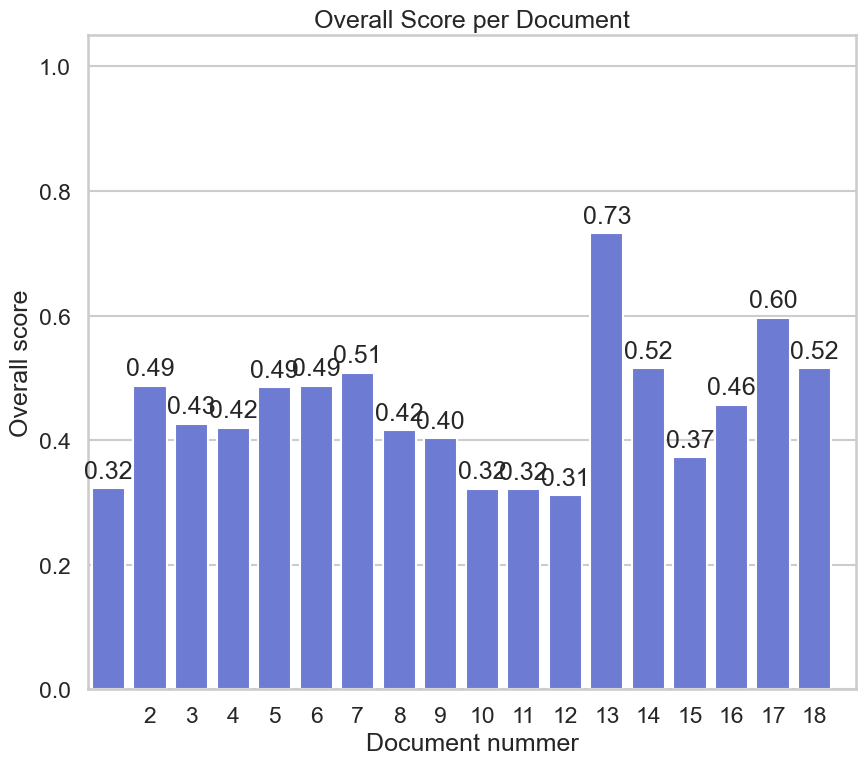

In [43]:
# overall score per document
plt.figure(figsize=(9, 8))

ax = sns.barplot(
    x="doc_number",
    y="document_overall_score",
    data=doc_overall_scores,
    color="#5D6FE4"
)

plt.xticks(doc_overall_scores["doc_number"])
plt.ylim(0, 1.05)
plt.xlabel("Document nummer")
plt.ylabel("Overall score")
plt.title("Overall Score per Document")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=4)

plt.tight_layout()
plt.savefig("overall_per_document.png")
plt.show()


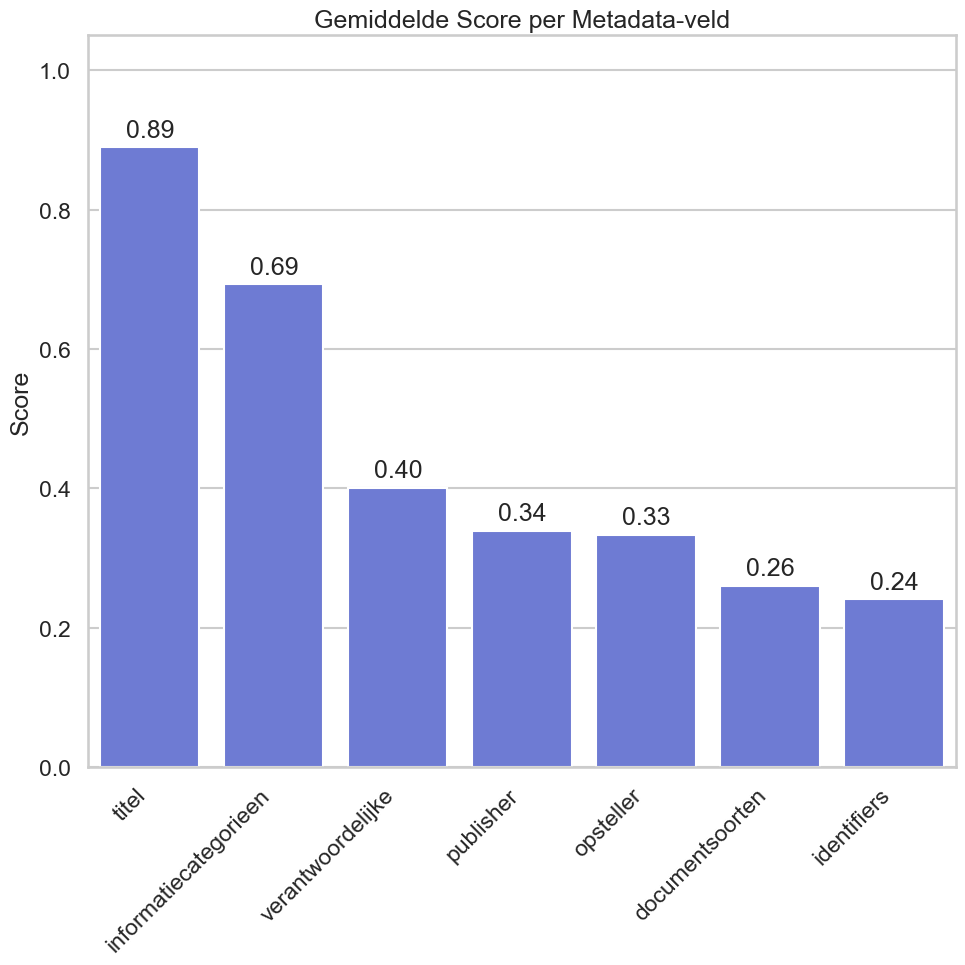

In [44]:
# gemiddelde score per veld
plt.figure(figsize=(10, 10))

ax = sns.barplot(
    x="field",
    y="field_average_score",
    data=field_average_scores,
    color="#5D6FE4"
)

plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.xlabel("")
plt.title("Gemiddelde Score per Metadata-veld")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=4)

plt.tight_layout()
plt.savefig("average_per_field.png")
plt.show()



### PDF rapport genereren

In [45]:
import matplotlib.pyplot as plt
from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle,
    ListFlowable, ListItem, PageBreak
)
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors
from reportlab.lib.units import inch
from reportlab.lib.pagesizes import A4

# =============================
# Aggregaties
# =============================

doc_overall_scores = (
    benchmark_df
    .groupby("doc_id")["score"]
    .mean()
    .reset_index()
    .rename(columns={"score": "document_overall_score"})
)

doc_overall_scores = doc_overall_scores.reset_index(drop=True)
doc_overall_scores["doc_number"] = doc_overall_scores.index + 1

field_average_scores = (
    benchmark_df
    .groupby("field")["score"]
    .mean()
    .reset_index()
    .rename(columns={"score": "field_average_score"})
    .sort_values("field_average_score", ascending=False)
)

total_overall_score = doc_overall_scores["document_overall_score"].mean()

# =============================
# Nettere Visualisaties
# =============================

plt.figure(figsize=(8, 4))
plt.bar(doc_overall_scores["doc_number"],
        doc_overall_scores["document_overall_score"])
plt.xticks(doc_overall_scores["doc_number"])
plt.ylim(0, 1)
plt.xlabel("Document nummer")
plt.ylabel("Overall score (0-1)")
plt.title("Overall Score per Document")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("overall_per_document.png")
plt.close()

plt.figure(figsize=(8, 4))
plt.bar(field_average_scores["field"],
        field_average_scores["field_average_score"])
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.ylabel("Score (0-1)")
plt.title("Gemiddelde Score per Metadata-veld")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("average_per_field.png")
plt.close()

# =============================
# Voorbeeldvergelijkingen (met wrapping)
# =============================

styles = getSampleStyleSheet()

small_style = ParagraphStyle(
    name="Small",
    parent=styles["Normal"],
    fontSize=8,
    leading=10
)

sample_rows = benchmark_df.head(10)

example_table_data = [
    ["Doc", "Veld", "Officieel", "LLM", "Score"]
]

for _, row in sample_rows.iterrows():
    example_table_data.append([
        Paragraph(row["doc_id"][:8], small_style),
        Paragraph(str(row["field"]), small_style),
        Paragraph(str(row["official_value"]), small_style),
        Paragraph(str(row["llm_value"]), small_style),
        Paragraph(str(round(row["score"], 3)), small_style),
    ])

# =============================
# PDF Genereren
# =============================

pdf_path = "LLM_Metadata_Benchmark_Report_Final.pdf"
doc = SimpleDocTemplate(pdf_path, pagesize=A4)
elements = []

title_style = styles["Heading1"]
section_style = styles["Heading2"]
normal = styles["Normal"]

# Titel
elements.append(Paragraph("LLM Metadata Benchmark Report", title_style))
elements.append(Spacer(1, 20))

# Introductie
elements.append(Paragraph("Introductie", section_style))
elements.append(Spacer(1, 10))

intro_text = """
Om te beoordelen of het genereren van metadata door een Large Language Model (LLM) 
voldoende betrouwbaar is voor documenten die gepubliceerd worden via de 
GPP-WOO publicatiebank, is een benchmarktest uitgevoerd.

Voor deze benchmark zijn 20 documenten geselecteerd via OpenOverheid 
(https://open.overheid.nl/home). Voor elk document in deze testset wordt de 
officiële metadata vergeleken met de door het LLM gegenereerde metadata.

De vergelijking richt zich uitsluitend op de metadata-velden die daadwerkelijk 
worden gebruikt binnen het publicatieproces van de GPP-WOO publicatiebank.

De toegepaste vergelijkingsmethode verschilt per type veld. Afhankelijk van de 
aard van het veld wordt gebruikgemaakt van fuzzy string similarity, set overlap 
of semantische overlap. Op basis hiervan wordt per veld en per document een score 
berekend, waarna geaggregeerde resultaten inzicht geven in de algemene prestaties 
van het LLM.
"""

elements.append(Paragraph(intro_text, normal))
elements.append(Spacer(1, 20))


# Methodiek
elements.append(Paragraph("Vergelijkingsmethodiek", section_style))
elements.append(Spacer(1, 10))

methods = [
    "Titel → Fuzzy string similarity",
    "Identifiers → Set overlap (Jaccard)",
    "Informatiecategorieën → Fuzzy semantische overlap",
    "Documentsoorten → Fuzzy overlap",
    "Publisher / Verantwoordelijke / Opsteller → Fuzzy string similarity"
]

elements.append(ListFlowable(
    [ListItem(Paragraph(m, normal)) for m in methods],
    bulletType="bullet"
))
elements.append(Spacer(1, 20))

# Resultaten
elements.append(Paragraph("Numerieke resultaten", section_style))
elements.append(Spacer(1, 10))

elements.append(Paragraph(
    f"Totaal gemiddelde overall score: {round(total_overall_score, 3)}",
    normal
))
elements.append(Spacer(1, 20))

field_table_data = [["Metadata-veld", "Gemiddelde score"]]
for _, row in field_average_scores.iterrows():
    field_table_data.append([row["field"], round(row["field_average_score"], 3)])

field_table = Table(field_table_data)
field_table.setStyle(TableStyle([
    ("BACKGROUND", (0, 0), (-1, 0), colors.lightgrey),
    ("GRID", (0, 0), (-1, -1), 0.5, colors.grey),
    ("VALIGN", (0, 0), (-1, -1), "MIDDLE"),
]))

elements.append(field_table)
elements.append(PageBreak())

# Visualisaties
elements.append(Paragraph("Visualisaties", section_style))
elements.append(Spacer(1, 20))
elements.append(Image("overall_per_document.png", width=5*inch, height=3*inch))
elements.append(Spacer(1, 20))
elements.append(Image("average_per_field.png", width=7/1.5*inch, height=4/1.5*inch))
elements.append(PageBreak())

# Voorbeelden
elements.append(Paragraph("4. Voorbeeldvergelijkingen", section_style))
elements.append(Spacer(1, 10))

example_table = Table(
    example_table_data,
    colWidths=[0.7*inch, 1.0*inch, 2.4*inch, 2.4*inch, 0.6*inch]
)

example_table.setStyle(TableStyle([
    ("BACKGROUND", (0, 0), (-1, 0), colors.lightgrey),
    ("GRID", (0, 0), (-1, -1), 0.3, colors.grey),
    ("VALIGN", (0, 0), (-1, -1), "TOP"),
    ("LEFTPADDING", (0, 0), (-1, -1), 4),
    ("RIGHTPADDING", (0, 0), (-1, -1), 4),
]))

elements.append(example_table)

doc.build(elements)

print("PDF gegenereerd:", pdf_path)


PDF gegenereerd: LLM_Metadata_Benchmark_Report_Final.pdf
